In [61]:
import fastf1
import fastf1.api
import fastf1.plotting

import pandas as pd
import numpy as np
import os  
from datetime import timedelta
import csv
import seaborn as sns
from fastf1.ergast import Ergast

ergast = Ergast()

year = 2025
race_number = 2
race_session = 'R'
Lap_Number = 70
team = 'Ferrari'
#year = int(input("Year ? "))
#race_number = int(input("Race Number ? (1-24) "))
#race_session = input('Session ?  (S, R) ')

session= fastf1.get_session(year, race_number, race_session)
session.load()

pit = ergast.get_pit_stops(season = year, round = race_number )
teams = fastf1.plotting.list_team_names(session)
team_drivers = fastf1.plotting.get_driver_abbreviations_by_team(team, session=session)
event_name = session.event.EventName

core           INFO 	Loading data for Chinese Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '4', '63', '1', '31', '12', '23', '87', '18', '55', '6', '30', '7', '5', '27', '22', '14', '16', '44', '10']
req            INFO 	Using cached data for driver_info


In [2]:
def highlight(s, min_max):
    if min_max == 'min':
        is_min_max = s == s.min()
    if min_max == 'max':
        is_min_max = s == s.max()

    return ['color: green' if v else 'color: orange' for v in is_min_max]

def background_color_df(s):
    colors= []
    for time_and_compound in s:
        if ' SOFT' in time_and_compound:
            colors.append('background-color:red')
        if ' MEDIUM' in time_and_compound:
            colors.append('background-color:yellow')
        if ' HARD' in time_and_compound:
            colors.append('background-color:white')
        if ' INTERMEDIATE' in time_and_compound:
            colors.append('background-color:green')
        if ' WET' in time_and_compound:
            colors.append('background-color:blue')
        if ' SUPERSOFT' in time_and_compound:
            colors.append('background-color:purple')
        if ' ULTRASOFT' in time_and_compound:
            colors.append('background-color:orangered')
        if ' HYPERSOFT' in time_and_compound:
            colors.append('background-color:pink')
        if ' SUPERHARD' in time_and_compound:
            colors.append('background-color:orange')
        if 'No data' in time_and_compound:
            colors.append('background-color:grey')
    return colors

def highlight_driver(s):
    drivers = []
    for driver_name in s:
        driver_color = fastf1.plotting.get_driver_color(driver_name[0:3], session)
        drivers.append(f'color: {driver_color}')
    return drivers

def color_df(s, color):
    colors= []
    for driver_name in s:
        colors.append(f'color:{color}')
    return colors

def is_personal_best_min(s, column):
    best_colors = []
    min_values = {}
    driver_ids = list(session.drivers)

    for driver_id in driver_ids:
        min_values[driver_id] = session.laps.pick_drivers(driver_id).pick_laps(range(0, Lap_Number + 1))[column].min()

    all_driver_laps = session.laps.pick_drivers(session.drivers).pick_laps(range(0, Lap_Number + 1))
    if not all_driver_laps.empty:
        overall_min = all_driver_laps[column].min()
    else:
        overall_min = 'inf'

    for column_value in s:
        color = 'color:orange'
        for driver in session.drivers:
            if column_value  == overall_min:
                color = 'color:purple'
            if column_value == min_values.get(driver):
                color = 'color:green'

        best_colors.append(color)

    return best_colors

def is_personal_best_max(s, column):
    best_colors = []
    max_values = {}
    driver_ids = list(session.drivers)

    for driver_id in driver_ids:
        max_values[driver_id] = session.laps.pick_drivers(driver_id).pick_laps(range(0, Lap_Number + 1))[column].max()

    all_driver_laps = session.laps.pick_drivers(session.drivers).pick_laps(range(0, Lap_Number + 1))
    if not all_driver_laps.empty:
        overall_max = all_driver_laps[column].max()
    else:
        overall_max = 0
    
    for column_value in s:
        color = 'color:orange'
        for driver in session.drivers:
            if column_value == overall_max:
                color = 'color:purple'
            elif column_value == max_values.get(driver):
                color = 'color:green'

        best_colors.append(color)

    return best_colors

def flag_color_row(s):
    flag_colors=[]
    for flag_color in s:
        match flag_color:
            case flag_color if 'GREEN' in flag_color:
                flag_colors.append('color:green')
            case flag_color if 'YELLOW' in flag_color:
                flag_colors.append('color:yellow')
            case flag_color if 'DOUBLE YELLOW' in flag_color:
                flag_colors.append('color:orange')
            case flag_color if 'RED' in flag_color:
                flag_colors.append('color:red')
            case flag_color if 'BLUE' in flag_color:
                flag_colors.append('color:blue')
            case flag_color if 'CLEAR' in flag_color:
                flag_colors.append('color:white')
            case flag_color if 'BLACK' in flag_color:
                flag_colors.append('color:dark-grey')
            case _:
                flag_colors.append('color:grey')
    return flag_colors

def get_wind_direction_cat(WindDirection):
    normalized_direction = WindDirection % 360
    if normalized_direction < 0:
        normalized_direction += 360
    match normalized_direction:
        case _ if (normalized_direction >= 348.75 or normalized_direction < 11.25):
            return 'N'
        case _ if (normalized_direction >= 11.25 and normalized_direction < 33.75):
            return 'NNE'
        case _ if (normalized_direction >= 33.75 and normalized_direction < 56.25):
            return 'NE'
        case _ if (normalized_direction >= 56.25 and normalized_direction < 78.75):
            return 'ENE'
        case _ if (normalized_direction >= 78.75 and normalized_direction < 101.25):
            return 'E'
        case _ if (normalized_direction >= 101.25 and normalized_direction < 123.75):
            return 'ESE'
        case _ if (normalized_direction >= 123.75 and normalized_direction < 146.25):
            return 'SE'
        case _ if (normalized_direction >= 146.25 and normalized_direction < 168.75):
            return 'SSE'
        case _ if (normalized_direction >= 168.75 and normalized_direction < 191.25):
            return 'S'
        case _ if (normalized_direction >= 191.25 and normalized_direction < 213.75):
            return 'SSW'
        case _ if (normalized_direction >= 213.75 and normalized_direction < 236.25):
            return 'SW'
        case _ if (normalized_direction >= 236.25 and normalized_direction < 258.75):
            return 'WSW'
        case _ if (normalized_direction >= 258.75 and normalized_direction < 281.25):
            return 'W'
        case _ if (normalized_direction >= 281.25 and normalized_direction < 303.75):
            return 'WNW'
        case _ if (normalized_direction >= 303.75 and normalized_direction < 326.25):
            return 'NW'
        case _ if (normalized_direction >= 326.25 and normalized_direction < 348.75):
            return 'NNW'
        case _:
            return 'Invalid'

tyres={
    'SOFT':'🔴',
    'MEDIUM':'🟡',
    'HARD':'⚪',
    'INTERMEDIATE':'🟢',
    'WET':'🔵',
    'SUPERSOFT': '🟣',
    'ULTRASOFT': '🟠',
    'HYPERSOFT': '🩷',
    'SUPERHARD': '🍊',
}


In [ ]:
on_track = []
on_track_df = []
on_track_logo = []
driver_names = []
for driver in session.drivers:
    each_lap = session.laps.pick_laps(Lap_Number).pick_drivers(driver)
    try:
        pos_lap = each_lap.get_pos_data()
        on_track.append('On Track')
        on_track_logo.append('🟢')
    except:
        on_track.append('DNF')
        on_track_logo.append('🔴')
on_track_df = pd.DataFrame()

on_track_df['Status']= on_track
on_track_df['PU']= on_track_logo
on_track_df.index = session.drivers
on_track_df

                       Date   Status       X       Y       Z Source  \
0   2025-06-29 14:40:39.646  OnTrack   990.0 -1238.0  7215.0    pos   
1   2025-06-29 14:40:39.986  OnTrack   817.0 -1284.0  7214.0    pos   
2   2025-06-29 14:40:40.286  OnTrack   498.0 -1370.0  7214.0    pos   
3   2025-06-29 14:40:40.705  OnTrack   125.0 -1471.0  7214.0    pos   
4   2025-06-29 14:40:41.105  OnTrack   -89.0 -1529.0  7214.0    pos   
..                      ...      ...     ...     ...     ...    ...   
264 2025-06-29 14:41:47.965  OnTrack  1919.0  -987.0  7221.0    pos   
265 2025-06-29 14:41:48.305  OnTrack  1653.0 -1059.0  7217.0    pos   
266 2025-06-29 14:41:48.505  OnTrack  1436.0 -1117.0  7215.0    pos   
267 2025-06-29 14:41:48.785  OnTrack  1287.0 -1158.0  7215.0    pos   
268 2025-06-29 14:41:49.005  OnTrack  1124.0 -1202.0  7215.0    pos   

                      Time            SessionTime  
0   0 days 00:00:00.040000 0 days 02:33:46.853000  
1   0 days 00:00:00.380000 0 days 02:33:47.

,Status,PU
4,On Track,🟢
81,On Track,🟢
16,On Track,🟢
44,On Track,🟢
63,On Track,🟢
30,On Track,🟢
14,DNF,🔴
5,DNF,🔴
27,DNF,🔴
31,DNF,🔴


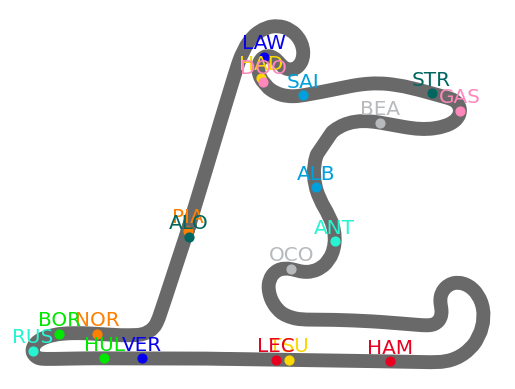

In [65]:
import matplotlib.pyplot as plt

def rotate(xy, *, angle):
    rot_mat = np.array([[np.cos(angle), np.sin(angle)],
                        [-np.sin(angle), np.cos(angle)]])
    return np.matmul(xy, rot_mat)

lap = session.laps.pick_fastest()
pos = lap.get_pos_data()
circuit_info = session.get_circuit_info()

track = pos.loc[:, ('X', 'Y')].to_numpy()
track_angle = circuit_info.rotation / 180 * np.pi

rotated_track = rotate(track, angle=track_angle)

plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False
fig, ax = plt.subplots()

ax.plot(rotated_track[:, 0], rotated_track[:, 1], linewidth=10, color='dimgrey')
ax.tick_params(axis='x', which='both', bottom=False,
                top=False, labelbottom=False)

ax.tick_params(axis='y', which='both', right=False,
                left=False, labelleft=False)
each_lap = session.laps.pick_laps(range(0, Lap_Number))
first_driver_session_time_in_microsec = int(str((each_lap.LapStartTime[each_lap.Position == 1 & (each_lap.LapNumber == max(each_lap.LapNumber))].values/1000)[0]).split(' ')[0])

for driver in session.drivers:

    each_lap = session.laps.pick_laps(range(0, Lap_Number)).pick_drivers(driver)
    each_lap = each_lap[each_lap.Position == each_lap.Position]
    each_lap_data = each_lap.get_pos_data()
    
    each_lap_pos_data = each_lap_data.loc[:, ('X', 'Y')].to_numpy()
    each_lap_rotated_data = rotate(each_lap_pos_data, angle=track_angle)
    each_lap_data.loc[:, 'X'] = each_lap_rotated_data[:, 0]
    each_lap_data.loc[:, 'Y'] = each_lap_rotated_data[:, 1]
    
    txt = each_lap.Driver.iloc[0]

    pos_x = (each_lap_data['X'].iloc[(each_lap_data['SessionTime'] - timedelta(microseconds = first_driver_session_time_in_microsec)).abs().argsort()[:1]])
    pos_y = (each_lap_data['Y'].iloc[(each_lap_data['SessionTime'] - timedelta(microseconds = first_driver_session_time_in_microsec)).abs().argsort()[:1]])

    ax.scatter(pos_x.iloc[0], pos_y.iloc[0], color=fastf1.plotting.get_driver_color(txt, session=session), s=40, zorder=2)
    ax.text(pos_x.iloc[0], pos_y.iloc[0]+400, txt, color=fastf1.plotting.get_driver_color(txt, session=session), 
            va='center_baseline', ha='center', size='x-large', zorder=3)


In [8]:
Lap_Number = 40
driver_data_last_laps = []

driver = team_drivers[0]
driver_lap = session.laps.pick_drivers(driver)
max_lap = int(max(driver_lap.LapNumber))

if Lap_Number<10:
    lap_range =range(0, min(Lap_Number, max_lap))
else :
    lap_range = range(min(Lap_Number-10, max_lap - 10), min(Lap_Number, max_lap))

for lap in lap_range:
    driver_data_cols = ['Time', 'Lap', 'Sector1', 'I1', 'Sector2', 'I2', 'Sector3', 'FL', 'LapTime', 'ST']
    
    try:

        driver_color = fastf1.plotting.get_driver_color(driver_lap.Driver.iloc[lap], session)
        driver_data = [driver_lap.Time.iloc[lap], driver_lap.LapNumber.iloc[lap], driver_lap.Sector1Time.iloc[lap], driver_lap.SpeedI1.iloc[lap], driver_lap.Sector2Time.iloc[lap], driver_lap.SpeedI2.iloc[lap], driver_lap.Sector3Time.iloc[lap], driver_lap.SpeedFL.iloc[lap], driver_lap.LapTime.iloc[lap], driver_lap.SpeedST.iloc[lap]]
    except:
        continue
    driver_data_series = pd.Series(driver_data, index=driver_data_cols)
    driver_data_last_laps.append(driver_data_series)

driver_data_last_laps_df = pd.DataFrame(driver_data_last_laps)

styled_df = driver_data_last_laps_df.style

styled_df = styled_df.apply(highlight, subset=['Sector1'], min_max='min')
styled_df = styled_df.apply(highlight, subset=['I1'], min_max='max')
styled_df = styled_df.apply(highlight, subset=['Sector2'], min_max='min')
styled_df = styled_df.apply(highlight, subset=['I2'], min_max='max')
styled_df = styled_df.apply(highlight, subset=['Sector3'], min_max='min')
styled_df = styled_df.apply(highlight, subset=['FL'], min_max='max')
styled_df = styled_df.apply(highlight, subset=['LapTime'], min_max='min')
styled_df = styled_df.apply(highlight, subset=['ST'], min_max='max')

formatters = {
    'Time': lambda x: str(x)[7:-3] if pd.notnull(x) else 'Ø',
    'Lap': lambda x: int(x) if pd.notnull(x) else 'Ø',
    'Sector1': lambda x: str(x)[13:-3] if pd.notnull(x) else 'Ø',
    'I1': lambda x: int(x) if pd.notnull(x) else 'Ø',
    'Sector2': lambda x: str(x)[13:-3] if pd.notnull(x) else 'Ø',
    'I2': lambda x: int(x) if pd.notnull(x) else 'Ø',
    'Sector3': lambda x: str(x)[13:-3] if pd.notnull(x) else 'Ø',
    'FL': lambda x: int(x) if pd.notnull(x) else 'Ø',
    'LapTime': lambda x: str(x)[11:-3] if pd.notnull(x) else 'Ø',
    'ST': lambda x: int(x) if pd.notnull(x) else 'Ø',
}

final_formatters = {k: v for k, v in formatters.items() if k in driver_data_last_laps_df.columns}
styled_df = styled_df.format(final_formatters)
styled_df

,Time,Lap,Sector1,I1,Sector2,I2,Sector3,FL,LapTime,ST
0,01:37:34.996,31,19.539,199,36.835,184,20.399,260,1:16.773,283
1,01:38:51.414,32,19.948,Ø,36.351,190,20.119,261,1:16.418,282
2,01:40:06.929,33,19.733,202,35.914,195,19.868,259,1:15.515,278
3,01:41:21.909,34,19.548,209,35.618,196,19.814,258,1:14.980,278
4,01:42:36.258,35,19.304,212,35.311,197,19.734,258,1:14.349,276
5,01:43:50.313,36,19.337,Ø,35.063,198,19.655,258,1:14.055,277
6,01:45:04.418,37,19.251,211,35.202,198,19.652,258,1:14.105,277
7,01:46:18.988,38,19.364,212,35.376,198,19.830,258,1:14.570,278
8,01:47:33.128,39,19.278,211,35.190,202,19.672,258,1:14.140,278
9,01:48:47.184,40,19.219,214,35.094,199,19.743,258,1:14.056,278


EACH DRIVER

In [9]:
def get_wind_direction_cat(WindDirection):
    normalized_direction = WindDirection % 360
    if normalized_direction < 0:
        normalized_direction += 360
    match normalized_direction:
        case _ if (normalized_direction >= 348.75 or normalized_direction < 11.25):
            return 'N'
        case _ if (normalized_direction >= 11.25 and normalized_direction < 33.75):
            return 'NNE'
        case _ if (normalized_direction >= 33.75 and normalized_direction < 56.25):
            return 'NE'
        case _ if (normalized_direction >= 56.25 and normalized_direction < 78.75):
            return 'ENE'
        case _ if (normalized_direction >= 78.75 and normalized_direction < 101.25):
            return 'E'
        case _ if (normalized_direction >= 101.25 and normalized_direction < 123.75):
            return 'ESE'
        case _ if (normalized_direction >= 123.75 and normalized_direction < 146.25):
            return 'SE'
        case _ if (normalized_direction >= 146.25 and normalized_direction < 168.75):
            return 'SSE'
        case _ if (normalized_direction >= 168.75 and normalized_direction < 191.25):
            return 'S'
        case _ if (normalized_direction >= 191.25 and normalized_direction < 213.75):
            return 'SSW'
        case _ if (normalized_direction >= 213.75 and normalized_direction < 236.25):
            return 'SW'
        case _ if (normalized_direction >= 236.25 and normalized_direction < 258.75):
            return 'WSW'
        case _ if (normalized_direction >= 258.75 and normalized_direction < 281.25):
            return 'W'
        case _ if (normalized_direction >= 281.25 and normalized_direction < 303.75):
            return 'WNW'
        case _ if (normalized_direction >= 303.75 and normalized_direction < 326.25):
            return 'NW'
        case _ if (normalized_direction >= 326.25 and normalized_direction < 348.75):
            return 'NNW'
        case _:
            return 'Invalid'

Lap_Number=10
minute=20

weather_driver_lap = session.laps.get_weather_data()
weather_driver_lap = weather_driver_lap.drop_duplicates()
weather_driver_lap = weather_driver_lap.sort_values(['Time'])
weather_driver_lap['Direction'] = weather_driver_lap['WindDirection'].apply(get_wind_direction_cat)
#weather_driver_lap['Time_sec'] = weather_driver_lap.Time.dt.total_seconds()
#print((weather_driver_lap.Time_sec.iloc[0] + 600))
weather_evolution = [weather_driver_lap.iloc[0],
                     weather_driver_lap.iloc[int(len(weather_driver_lap)/10)],
                     weather_driver_lap.iloc[int(len(weather_driver_lap)/10)*2],
                     weather_driver_lap.iloc[int(len(weather_driver_lap)/10)*3],
                     weather_driver_lap.iloc[int(len(weather_driver_lap)/10)*4],
                     weather_driver_lap.iloc[int(len(weather_driver_lap)/10)*5],
                     weather_driver_lap.iloc[int(len(weather_driver_lap)/10)*6],
                     weather_driver_lap.iloc[int(len(weather_driver_lap)/10)*7],
                     weather_driver_lap.iloc[int(len(weather_driver_lap)/10)*8],
                     weather_driver_lap.iloc[int(len(weather_driver_lap)/10)*9],
                     weather_driver_lap.iloc[int(len(weather_driver_lap)-1)]]
weather_evolution_df = pd.DataFrame(weather_evolution)
weather_evolution_df.Time = weather_evolution_df.Time.astype('str').str[7:-3]
weather_evolution_df.Humidity = weather_evolution_df.Humidity.astype('int')
#weather_evolution_df = weather_evolution_df.drop(columns=['Time_sec'])
weather_evolution_df

,Time,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed,Direction
56,00:56:18.747,22.0,51,1016.8,False,45.2,345,0.8,NNW
67,01:07:18.893,22.1,52,1016.9,False,44.1,317,0.8,NW
77,01:17:18.963,22.5,51,1016.9,False,44.3,327,0.8,NNW
87,01:27:18.999,22.5,52,1016.8,False,43.1,192,0.8,SSW
97,01:37:19.048,22.4,54,1016.8,False,43.7,181,1.0,S
107,01:47:19.124,22.8,52,1016.7,False,43.2,197,0.7,SSW
117,01:57:19.187,22.5,53,1016.5,False,43.2,34,0.5,NE
127,02:07:19.266,22.5,54,1016.5,False,42.2,245,1.1,WSW
137,02:17:19.304,22.6,51,1016.3,False,43.0,147,0.4,SSE
147,02:27:19.326,22.5,51,1016.2,False,42.6,0,0.8,N


CURENT STATUS

In [10]:
Lap_Number=10

def is_personal_best(s, column):
    best_colors = []

    min_values = {}
    driver_ids = list(session.drivers)

    for driver_id in driver_ids:
        try:
            min_values[driver_id] = session.laps.pick_drivers(driver_id).pick_laps(range(0, Lap_Number + 1))[column].min()
        except Exception:
            min_values[driver_id] = float('inf')

    overall_min = float('inf')
    try:
        all_driver_laps = session.laps.pick_drivers(session.drivers).pick_laps(range(0, Lap_Number + 1))
        if not all_driver_laps.empty:
            overall_min = all_driver_laps[column].min()
    except Exception:
        overall_min = float('inf')

    for column_value in s:
        color = 'color:orange'
        for driver in session.drivers:
            if column_value == session.laps.pick_drivers(81).pick_laps(range(0, Lap_Number+1))[column].min():
                color = 'color:purple'
            if column_value == min_values.get(driver):
                color = 'color:green'

        if column_value < overall_min:
            color = 'color:purple'

        best_colors.append(color)

    return best_colors

def color_df(s, color):
    colors= []
    for driver_name in s:
        colors.append(f'color:{color}')
    return colors

def highlight_compound(s):
    colors = []
    for compound_value in s:
        if compound_value == 'SOFT':
            colors.append('color: red')
        elif compound_value == 'MEDIUM':
            colors.append('color: yellow')
        elif compound_value == 'HARD':
            colors.append('color: white')
        elif compound_value == 'INTERMEDIATE':
            colors.append('color: green')
        elif compound_value == 'WET':
            colors.append('color: blue')
        else:
            colors.append('color: grey')
    return colors

def highlight_driver(s):
    drivers = []
    for driver_name in s:
        driver_name = driver_name.split(' ')[0]
        driver_color = fastf1.plotting.get_driver_color(driver_name, session)
        drivers.append(f'color: {driver_color}')
    return drivers


def is_personal_best_min(s, column):
    best_colors = []
    min_values = {}
    driver_ids = list(session.drivers)

    for driver_id in driver_ids:
        min_values[driver_id] = session.laps.pick_drivers(driver_id).pick_laps(range(0, Lap_Number + 1))[column].min()

    all_driver_laps = session.laps.pick_drivers(session.drivers).pick_laps(range(0, Lap_Number + 1))
    if not all_driver_laps.empty:
        overall_min = all_driver_laps[column].min()
    else:
        overall_min = 'inf'

    for column_value in s:
        color = 'color:orange'
        for driver in session.drivers:
            if column_value  == overall_min:
                color = 'color:purple'
            if column_value == min_values.get(driver):
                color = 'color:green'

        best_colors.append(color)

    return best_colors

def is_personal_best_max(s, column):
    best_colors = []
    max_values = {}
    driver_ids = list(session.drivers)

    for driver_id in driver_ids:
        max_values[driver_id] = session.laps.pick_drivers(driver_id).pick_laps(range(0, Lap_Number + 1))[column].max()

    all_driver_laps = session.laps.pick_drivers(session.drivers).pick_laps(range(0, Lap_Number + 1))
    if not all_driver_laps.empty:
        overall_max = all_driver_laps[column].max()
    else:
        overall_max = 0
    
    for column_value in s:
        color = 'color:orange'
        for driver in session.drivers:
            if column_value == overall_max:
                color = 'color:purple'
            elif column_value == max_values.get(driver):
                color = 'color:green'

        best_colors.append(color)

    return best_colors

tyres={
    'SOFT':'🔴',
    'MEDIUM':'🟡',
    'HARD':'⚪',
    'INTERMEDIATE':'🟢',
    'WET':'🔵',
    'SUPERSOFT': '🟣',
    'ULTRASOFT': '🟠',
    'HYPERSOFT': '🩷',
    'SUPERHARD': '🍊',
}

race_session = 'Practice 1'
if race_session == 'Practice 1':
    drivers_data = []
    driver_data_cols = [
        'Driver', 'Time',
        'Gap_ahead_Driver', 'Gap_to_Leader',
        'Sector1', 'I1', 'Sector2', 'I2', 'Sector3',
        'FL', 'LapTime', 'ST', 'Lap', 'Tyre', 'PitStop'
    ]
    fastest_lap_drivers = []
    for driver in session.drivers:
        fastest_lap_per_driver = session.laps.pick_drivers(driver).pick_fastest()
        try:
            if not fastest_lap_per_driver.empty:
                fastest_lap_per_driver = [
                    fastest_lap_per_driver.Driver  + ' ❚ ' + fastest_lap_per_driver.DriverNumber,
                    fastest_lap_per_driver.Time, 0, 0, fastest_lap_per_driver.Sector1Time, fastest_lap_per_driver.SpeedI1,
                    fastest_lap_per_driver.Sector2Time, fastest_lap_per_driver.SpeedI2, fastest_lap_per_driver.Sector3Time,
                    fastest_lap_per_driver.SpeedFL, fastest_lap_per_driver.LapTime, fastest_lap_per_driver.SpeedST,
                    fastest_lap_per_driver.LapNumber, fastest_lap_per_driver.Compound, (fastest_lap_per_driver.Stint - 1)
                ]
        except:
            continue
        fastest_lap_drivers.append(pd.Series(fastest_lap_per_driver, index=driver_data_cols))
        fastest_laps = pd.DataFrame(fastest_lap_drivers)
        
        fastest_laps['Tyre'] = fastest_laps.Tyre.replace(to_replace=tyres)
        fastest_laps = fastest_laps.sort_values(['LapTime'])
        fastest_laps['Gap_ahead_Driver'] = fastest_laps['LapTime'].diff()
        fastest_laps['Gap_to_Leader'] = fastest_laps['LapTime'] - fastest_laps['LapTime'].iloc[0]
        fastest_laps.index = range(1, len(fastest_laps) +1 )

    if fastest_laps.empty:
        print(f"No driver data collected for this scenario. Check session data and logic.")
    else:
        styled_df = fastest_laps.style
        styled_df = styled_df.apply(highlight_driver, subset=['Driver'])
        styled_df = styled_df.apply(is_personal_best_min, subset=['Sector1'], column = 'Sector1Time')
        styled_df = styled_df.apply(is_personal_best_min, subset=['Sector2'], column = 'Sector2Time')
        styled_df = styled_df.apply(is_personal_best_min, subset=['Sector3'], column = 'Sector3Time')
        styled_df = styled_df.apply(is_personal_best_min, subset=['LapTime'], column = 'LapTime')
        styled_df = styled_df.apply(is_personal_best_max, subset=['I1'], column = 'SpeedI1')
        styled_df = styled_df.apply(is_personal_best_max, subset=['I2'], column = 'SpeedI2')
        styled_df = styled_df.apply(is_personal_best_max, subset=['FL'], column = 'SpeedFL')
        styled_df = styled_df.apply(is_personal_best_max, subset=['ST'], column = 'SpeedST')
        styled_df = styled_df.apply(color_df, subset=['Gap_ahead_Driver'], color ='orange')
        styled_df = styled_df.apply(color_df, subset=['Gap_to_Leader'], color ='orange')

        formatters = {
        
        'Time': lambda x: str(x)[7:-3] if pd.notnull(x) else 'No Data',
        'Sector1': lambda x: str(x)[13:-3] if pd.notnull(x) else 'No Data',
        'I1': lambda x: int(x) if pd.notnull(x) else 'No Data',
        'Sector2': lambda x: str(x)[13:-3] if pd.notnull(x) else 'No Data',
        'I2': lambda x: int(x) if pd.notnull(x) else 'No Data',
        'Sector3': lambda x: str(x)[13:-3] if pd.notnull(x) else 'No Data',
        'FL': lambda x: int(x) if pd.notnull(x) else 'No Data',
        'LapTime': lambda x: str(x)[11:-3] if pd.notnull(x) else 'No Data',
        'ST': lambda x: int(x) if pd.notnull(x) else 'No Data',
        'Lap': lambda x: int(x) if pd.notnull(x) else 'No Data',
        'PitStop': lambda x: int(x) if pd.notnull(x) else 'No Data',
        'Gap_ahead_Driver': lambda x: str(abs(x))[14:-3] if pd.notnull(x) else 'No Data',
        'Gap_to_Leader': lambda x: str(x)[14:-3] if pd.notnull(x) else 'No Data',
        }

        final_formatters = {k: v for k, v in formatters.items() if k in fastest_laps.columns}
        styled_df = styled_df.format(final_formatters)
styled_df

,Driver,Time,Gap_ahead_Driver,Gap_to_Leader,Sector1,I1,Sector2,I2,Sector3,FL,LapTime,ST,Lap,Tyre,PitStop
1,NOR ❚ 4,02:36:42.913,No Data,,19.145,213,34.697,202,19.379,261,1:13.221,282,78,⚪,2
2,RUS ❚ 63,02:34:48.494,0.184,0.184,19.211,211,34.690,202,19.504,259,1:13.405,279,74,⚪,2
3,ANT ❚ 12,02:35:36.488,0.113,0.297,19.187,212,34.864,197,19.467,261,1:13.518,283,74,⚪,2
4,PIA ❚ 81,02:14:07.976,0.227,0.524,19.388,207,34.787,199,19.570,262,1:13.745,282,60,⚪,2
5,SAI ❚ 55,02:26:54.249,0.243,0.767,19.340,212,35.166,199,19.482,260,1:13.988,279,68,🟡,2
6,LEC ❚ 16,01:43:50.313,0.067,0.834,19.337,No Data,35.063,198,19.655,258,1:14.055,277,36,⚪,1
7,HAM ❚ 44,02:31:12.097,0.035,0.869,19.375,208,35.138,199,19.577,260,1:14.090,277,73,🟡,2
8,VER ❚ 1,01:55:10.368,0.140,1.009,19.363,207,35.111,199,19.756,260,1:14.230,280,45,🟡,1
9,ALB ❚ 23,02:34:25.406,0.367,1.376,19.592,209,35.332,195,19.673,259,1:14.597,282,74,⚪,2
10,BEA ❚ 87,01:06:02.548,0.258,1.634,19.719,208,35.412,192,19.724,255,1:14.855,276,6,⚪,1


In [11]:
Lap_Number=6

def is_personal_best(s, column):
    best_colors = []

    min_values = {}
    driver_ids = list(session.drivers)

    for driver_id in driver_ids:
        try:
            min_values[driver_id] = session.laps.pick_drivers(driver_id).pick_laps(range(0, Lap_Number + 1))[column].min()
        except Exception:
            min_values[driver_id] = float('inf')

    overall_min = float('inf')
    try:
        all_driver_laps = session.laps.pick_drivers(drivers_data_df.Driver).pick_laps(range(0, Lap_Number + 1))
        if not all_driver_laps.empty:
            overall_min = all_driver_laps[column].min()
    except Exception:
        overall_min = float('inf')

    for column_value in s:
        color = 'color:orange'
        for driver in session.drivers:
            if column_value == session.laps.pick_drivers(81).pick_laps(range(0, Lap_Number+1))[column].min():
                color = 'color:purple'
            if column_value == min_values.get(driver):
                color = 'color:green'

        if column_value < overall_min:
            color = 'color:purple'

        best_colors.append(color)

    return best_colors

def color_df(s, color):
    colors= []
    for driver_name in s:
        colors.append(f'color:{color}')
    return colors

def highlight_compound(s):
    colors = []
    for compound_value in s:
        if compound_value == 'SOFT':
            colors.append('color: red')
        elif compound_value == 'MEDIUM':
            colors.append('color: yellow')
        elif compound_value == 'HARD':
            colors.append('color: white')
        elif compound_value == 'INTERMEDIATE':
            colors.append('color: green')
        elif compound_value == 'WET':
            colors.append('color: blue')
        else:
            colors.append('color: grey')
    return colors

def highlight_driver(s):
    drivers = []
    for driver_name in s:
        if driver_name == 'VER' or driver_name == 'TSU':
            drivers.append('color: #0600ef')
        elif driver_name == 'GAS' or driver_name == 'DOO' or driver_name == 'COL':
            drivers.append('color: #ff87bc')
        elif driver_name == 'RUS' or driver_name == 'ANT':
            drivers.append('color: #27f4d2')
        elif driver_name == 'ALO' or driver_name == 'STR':
            drivers.append('color: #00665f')
        elif driver_name == 'LEC' or driver_name == 'HAM':
            drivers.append('color: #e80020')
        elif driver_name == 'ALB' or driver_name == 'SAI':
            drivers.append('color: #00a0dd')
        elif driver_name == 'HUL' or driver_name == 'BOR':
            drivers.append('color: #00e700')
        elif driver_name == 'HAD' or driver_name == 'LAW':
            drivers.append('color: #fcd700')
        elif driver_name == 'BEA' or driver_name == 'OCO':
            drivers.append('color: #b6babd')
        elif driver_name == 'NOR' or driver_name == 'PIA':
            drivers.append('color: #ff8000')
        else:
            drivers.append('color: grey')
    return drivers

drivers_data = []
driver_data_cols = [
    'Position', '№_Driver', 'Driver_Color', 'Driver', 'Time',
    'Gap_ahead_Driver', 'Gap_to_Leader',
    'Sector1', 'I1', 'Sector2', 'I2', 'Sector3',
    'FL', 'LapTime', 'ST', 'Lap', 'Compound', 'PitStop'
]

leader_driver_number = None
leader_lap_time_reference = None
leader_snapshot_lap_data = None

laps_at_snapshot = session.laps[session.laps['LapNumber'] == Lap_Number]

if not laps_at_snapshot.empty:
    leader_snapshot_lap_data = laps_at_snapshot.sort_values(by='Position').iloc[0]
    leader_driver_number = leader_snapshot_lap_data['DriverNumber']
    leader_lap_time_reference = leader_snapshot_lap_data['Time']
    try:
        leader_color = fastf1.plotting.get_driver_color(leader_snapshot_lap_data.Driver, session)
        leader_data = [
            leader_snapshot_lap_data.Position, leader_driver_number, leader_color, leader_snapshot_lap_data.Driver,
            leader_snapshot_lap_data.Time, 0, 0, leader_snapshot_lap_data.Sector1Time, leader_snapshot_lap_data.SpeedI1,
            leader_snapshot_lap_data.Sector2Time, leader_snapshot_lap_data.SpeedI2, leader_snapshot_lap_data.Sector3Time,
            leader_snapshot_lap_data.SpeedFL, leader_snapshot_lap_data.LapTime, leader_snapshot_lap_data.SpeedST,
            leader_snapshot_lap_data.LapNumber, leader_snapshot_lap_data.Compound, (leader_snapshot_lap_data.Stint - 1)
        ]
        drivers_data.append(pd.Series(leader_data, index=driver_data_cols))
    except Exception as e:
        print(f"Could not process leader's data for Lap {Lap_Number}. Error: {e}")
        exit()
else:
    print(f"No data available for Lap {Lap_Number} to determine the leader. Cannot proceed.")
    exit()


for driver_num in session.drivers:
    if driver_num == leader_driver_number:
        continue

    driver_laps = session.laps.pick_drivers(driver_num)
    potential_laps_after_leader = driver_laps[(driver_laps['Time'] >= leader_lap_time_reference)].copy()
    selected_lap = None
    if not potential_laps_after_leader.empty:
        selected_lap = potential_laps_after_leader.sort_values(by='LapNumber').iloc[0]
    else:
        fallback_lap = driver_laps[driver_laps['LapNumber'] == Lap_Number]
        if not fallback_lap.empty:
            selected_lap = fallback_lap.iloc[0]
        else:
            if not driver_laps.empty:
                selected_lap = driver_laps.iloc[-1]
            else:
                continue

    if selected_lap is not None and not selected_lap.empty:
        try:
            driver_color = fastf1.plotting.get_driver_color(selected_lap.Driver, session)
            driver_data = [
                selected_lap.Position, driver_num, driver_color, selected_lap.Driver,
                selected_lap.Time, 0, 0, selected_lap.Sector1Time, selected_lap.SpeedI1,
                selected_lap.Sector2Time, selected_lap.SpeedI2, selected_lap.Sector3Time,
                selected_lap.SpeedFL, selected_lap.LapTime, selected_lap.SpeedST,
                selected_lap.LapNumber, selected_lap.Compound, (selected_lap.Stint - 1)
            ]
            drivers_data.append(pd.Series(driver_data, index=driver_data_cols))
        except Exception as e:
            continue

drivers_data_df = pd.DataFrame(drivers_data)

if drivers_data_df.empty:
    print(f"No driver data collected for this scenario. Check session data and logic.")
else:
    drivers_data_df = drivers_data_df.fillna(0).infer_objects(copy=False)
    drivers_data_df = drivers_data_df.sort_values('Position').reset_index(drop=True)

    drivers_data_df['Time_td'] = drivers_data_df['Time']
    drivers_data_df['Gap_ahead_Driver'] = drivers_data_df['Time_td'].diff()
    drivers_data_df['Gap_to_Leader'] = drivers_data_df['Time_td'] - drivers_data_df['Time_td'].iloc[0]
   
    drivers_data_df = drivers_data_df.drop(columns=['Time_td', 'Driver_Color'])
    drivers_data_df = drivers_data_df[drivers_data_df['Position']>0]

    styled_df = drivers_data_df.style
    styled_df = styled_df.apply(highlight_driver, subset=['Driver'])
    styled_df = styled_df.apply(is_personal_best, subset=['Sector1'], column = 'Sector1Time')
    styled_df = styled_df.apply(is_personal_best, subset=['Sector2'], column = 'Sector2Time')
    styled_df = styled_df.apply(is_personal_best, subset=['Sector3'], column = 'Sector3Time')
    styled_df = styled_df.apply(is_personal_best, subset=['LapTime'], column = 'LapTime')
    styled_df = styled_df.apply(color_df, subset=['Gap_ahead_Driver'], color ='orange')
    styled_df = styled_df.apply(color_df, subset=['Gap_to_Leader'], color ='orange')
    styled_df = styled_df.apply(highlight_compound, subset=['Compound'])

    formatters = {
    
    'Position': lambda x: int(x) if pd.notnull(x) else 'No Data',
    'Time': lambda x: str(x)[7:-3] if pd.notnull(x) else 'No Data',
    'Sector1': lambda x: str(x)[13:-3] if pd.notnull(x) else 'No Data',
    'I1': lambda x: int(x) if pd.notnull(x) else 'No Data',
    'Sector2': lambda x: str(x)[13:-3] if pd.notnull(x) else 'No Data',
    'I2': lambda x: int(x) if pd.notnull(x) else 'No Data',
    'Sector3': lambda x: str(x)[13:-3] if pd.notnull(x) else 'No Data',
    'FL': lambda x: int(x) if pd.notnull(x) else 'No Data',
    'LapTime': lambda x: str(x)[11:-3] if pd.notnull(x) else 'No Data',
    'ST': lambda x: int(x) if pd.notnull(x) else 'No Data',
    'Lap': lambda x: int(x) if pd.notnull(x) else 'No Data',
    'PitStop': lambda x: int(x) if pd.notnull(x) else 'No Data',
    'Gap_ahead_Driver': lambda x: str(abs(x))[7:-3] if pd.notnull(x) else 'No Data',
    'Gap_to_Leader': lambda x: str(x)[7:-3] if pd.notnull(x) else 'No Data',
    }

    final_formatters = {k: v for k, v in formatters.items() if k in drivers_data_df.columns}
    styled_df = styled_df.format(final_formatters)
styled_df
    

,Position,№_Driver,Driver,Time,Gap_ahead_Driver,Gap_to_Leader,Sector1,I1,Sector2,I2,Sector3,FL,LapTime,ST,Lap,Compound,PitStop
0,1,4,NOR,01:05:24.845,No Data,00:00,20.643,0,37.367,180,21.162,254,1:19.172,266,6,MEDIUM,0
1,2,16,LEC,01:05:26.441,00:00:01.596,00:00:01.596,20.621,195,37.804,184,20.842,254,1:19.267,271,6,MEDIUM,0
2,3,81,PIA,01:05:30.370,00:00:03.929,00:00:05.525,20.928,193,37.577,183,21.288,255,1:19.793,273,6,MEDIUM,0
3,4,1,VER,01:05:32.324,00:00:01.954,00:00:07.479,21.370,182,37.325,181,21.316,254,1:20.011,265,6,HARD,0
4,5,6,HAD,01:05:33.478,00:00:01.154,00:00:08.633,21.128,185,37.732,182,21.283,253,1:20.143,270,6,MEDIUM,0
5,6,14,ALO,01:05:34.724,00:00:01.246,00:00:09.879,21.360,184,38.050,179,21.014,257,1:20.424,278,6,HARD,0
6,7,44,HAM,01:05:35.137,00:00:00.413,00:00:10.292,21.356,172,37.870,185,20.999,261,1:20.225,274,6,HARD,0
7,8,31,OCO,01:05:36.112,00:00:00.975,00:00:11.267,21.421,169,37.785,183,21.300,264,1:20.506,277,6,MEDIUM,0
8,9,30,LAW,01:05:38.067,00:00:01.955,00:00:13.222,21.104,167,38.602,183,21.836,254,1:21.542,274,6,MEDIUM,0
9,10,23,ALB,01:05:38.944,00:00:00.877,00:00:14.099,21.354,182,38.432,172,21.640,253,1:21.426,277,6,MEDIUM,0


In [12]:
drivers_data = []
driver_data_cols = ['Time', 'Position', 'Driver_Number', 'Driver_Color', 'Driver_Name', 'Status']
for driver in session.drivers:
    driver_lap = session.laps.pick_drivers(driver)
    try:
        driver_color = fastf1.plotting.get_driver_color(driver_lap.Driver.iloc[Lap_Number], session)
        driver_data = [driver_lap.Time.iloc[Lap_Number], driver_lap.Position.iloc[Lap_Number], driver, driver_color, driver_lap.Driver.iloc[Lap_Number], driver_lap.Time.iloc[Lap_Number]]
    except:
        continue
    driver_data_series = pd.Series(driver_data, index=driver_data_cols)
    drivers_data.append(driver_data_series)
drivers_data_df = pd.DataFrame(drivers_data)
drivers_data_df = drivers_data_df.fillna(0)
drivers_data_df.Time = drivers_data_df.Time.astype('str').str[6:-3]
drivers_data_df.Position = drivers_data_df.Position.astype('int')
drivers_data_df.Status = drivers_data_df.Status.astype('str').str[6:-3]
drivers_data_df

,Time,Position,Driver_Number,Driver_Color,Driver_Name,Status
0,01:06:43.315,1,4,#ff8000,NOR,01:06:43.315
1,01:06:45.097,2,16,#e80020,LEC,01:06:45.097
2,01:06:49.631,3,81,#ff8000,PIA,01:06:49.631
3,01:06:51.292,4,1,#0600ef,VER,01:06:51.292
4,01:06:56.068,7,44,#e80020,HAM,01:06:56.068
5,01:06:53.032,5,6,#fcd700,HAD,01:06:53.032
6,01:06:56.657,8,31,#b6babd,OCO,01:06:56.657
7,01:06:59.574,9,30,#fcd700,LAW,01:06:59.574
8,01:07:00.231,10,23,#00a0dd,ALB,01:07:00.231
9,01:07:01.499,11,55,#00a0dd,SAI,01:07:01.499


PER DRIVER

In [13]:
Lap_Number = 7
driver_data_last_laps = []

def highlight(s, min_max):
    if min_max == 'min':
        is_min_max = s == s.min()
    if min_max == 'max':
        is_min_max = s == s.min()

    return ['color: green' if v else 'color: orange' for v in is_min_max]

if Lap_Number<10:
    for Lap_Number in range(0, Lap_Number+1):
        driver_data_cols = ['Time', 'LapNumber', 'Sector1_Time', 'SpeedI1', 'Sector2_Time', 'SpeedI2', 'Sector3_Time', 'SpeedFL', 'LapTime', 'SpeedST']
        driver = 4
        driver_lap = session.laps.pick_drivers(driver)
        try:
            driver_color = fastf1.plotting.get_driver_color(driver_lap.Driver.iloc[Lap_Number], session)
            driver_data = [driver_lap.Time.iloc[Lap_Number], driver_lap.LapNumber.iloc[Lap_Number], driver_lap.Sector1Time.iloc[Lap_Number], driver_lap.SpeedI1.iloc[Lap_Number], driver_lap.Sector2Time.iloc[Lap_Number], driver_lap.SpeedI2.iloc[Lap_Number], driver_lap.Sector3Time.iloc[Lap_Number], driver_lap.SpeedFL.iloc[Lap_Number], driver_lap.LapTime.iloc[Lap_Number], driver_lap.SpeedST.iloc[Lap_Number]]
        except:
            continue
        driver_data_series = pd.Series(driver_data, index=driver_data_cols)
        driver_data_last_laps.append(driver_data_series)
    driver_data_last_laps_df = pd.DataFrame(driver_data_last_laps)
    styled_df = driver_data_last_laps_df.style
else:
    for Lap_Number in range(Lap_Number-9, Lap_Number+1):
        driver_data_cols = ['Time', 'LapNumber', 'Sector1_Time', 'SpeedI1', 'Sector2_Time', 'SpeedI2', 'Sector3_Time', 'SpeedFL', 'LapTime', 'SpeedST']
        driver = 4
        driver_lap = session.laps.pick_drivers(driver)
        try:
            driver_color = fastf1.plotting.get_driver_color(driver_lap.Driver.iloc[Lap_Number], session)
            driver_data = [driver_lap.Time.iloc[Lap_Number], driver_lap.LapNumber.iloc[Lap_Number], driver_lap.Sector1Time.iloc[Lap_Number], driver_lap.SpeedI1.iloc[Lap_Number], driver_lap.Sector2Time.iloc[Lap_Number], driver_lap.SpeedI2.iloc[Lap_Number], driver_lap.Sector3Time.iloc[Lap_Number], driver_lap.SpeedFL.iloc[Lap_Number], driver_lap.LapTime.iloc[Lap_Number], driver_lap.SpeedST.iloc[Lap_Number]]
        except:
            continue
        driver_data_series = pd.Series(driver_data, index=driver_data_cols)
        driver_data_last_laps.append(driver_data_series)
    driver_data_last_laps_df = pd.DataFrame(driver_data_last_laps)
    styled_df = driver_data_last_laps_df.style

styled_df = styled_df.apply(highlight, subset=['Sector1_Time'], min_max='min')
styled_df = styled_df.apply(highlight, subset=['SpeedI1'], min_max='max')
styled_df = styled_df.apply(highlight, subset=['Sector2_Time'], min_max='min')
styled_df = styled_df.apply(highlight, subset=['SpeedI2'], min_max='max')
styled_df = styled_df.apply(highlight, subset=['Sector3_Time'], min_max='min')
styled_df = styled_df.apply(highlight, subset=['SpeedFL'], min_max='max')
styled_df = styled_df.apply(highlight, subset=['LapTime'], min_max='min')
styled_df = styled_df.apply(highlight, subset=['SpeedST'], min_max='max')

formatters = {
    'Time': lambda x: str(x)[7:-3] if pd.notnull(x) else 'No Data',
    'LapNumber': lambda x: int(x) if pd.notnull(x) else 'No Data',
    'Sector1_Time': lambda x: str(x)[13:-3] if pd.notnull(x) else 'No Data',
    'SpeedI1': lambda x: int(x) if pd.notnull(x) else 'No Data',
    'Sector2_Time': lambda x: str(x)[13:-3] if pd.notnull(x) else 'No Data',
    'SpeedI2': lambda x: int(x) if pd.notnull(x) else 'No Data',
    'Sector3_Time': lambda x: str(x)[13:-3] if pd.notnull(x) else 'No Data',
    'SpeedFL': lambda x: int(x) if pd.notnull(x) else 'No Data',
    'LapTime': lambda x: str(x)[11:-3] if pd.notnull(x) else 'No Data',
    'SpeedST': lambda x: int(x) if pd.notnull(x) else 'No Data',
}

final_formatters = {k: v for k, v in formatters.items() if k in driver_data_last_laps_df.columns}
styled_df = styled_df.format(final_formatters)

styled_df

,Time,LapNumber,Sector1_Time,SpeedI1,Sector2_Time,SpeedI2,Sector3_Time,SpeedFL,LapTime,SpeedST
0,00:57:32.410,1,No Data,189,37.264,176,21.219,252,1:23.340,267
1,00:59:17.044,2,34.072,97,44.185,144,26.377,136,1:44.634,252
2,01:01:06.059,3,30.118,147,49.715,173,29.182,213,1:49.015,250
3,01:02:47.623,4,31.321,141,47.988,121,22.255,253,1:41.564,248
4,01:04:05.673,5,20.559,200,36.559,180,20.932,254,1:18.050,272
5,01:05:24.845,6,20.643,No Data,37.367,180,21.162,254,1:19.172,266
6,01:06:43.315,7,20.536,196,37.171,189,20.763,254,1:18.470,273
7,01:08:00.941,8,20.324,198,36.551,188,20.751,255,1:17.626,272


In [1]:
import urllib.request as request
import json
import requests
from jsonstream import load
from io import StringIO
import logging
def radio():
    print("Team Radio")
    with request.urlopen('http://livetiming.formula1.com/static/SessionInfo.json') as response:
        if response.getcode() == 200:
                logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)
                logging.info('Getting the URL')
                source = response.read()
                data = json.loads(source)
                location = "http://livetiming.formula1.com/static/" + data['Path'] + "TeamRadio.json"
                logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)
                logging.info('URL Successfully Found')
                url = location
                print(url)
                r = requests.get(location)
                r.encoding = 'utf-8-sig'
                out = json.loads(r.text)
                print(json.dumps(out, indent = 4))
                output = json.dumps(out, indent = 4)
                
        else:
            print('Unknown Error Occured')

In [3]:
radio()

2025-07-29 14:42:37,009 - Getting the URL
2025-07-29 14:42:37,011 - URL Successfully Found


Team Radio
http://livetiming.formula1.com/static/2025/2025-07-27_Belgian_Grand_Prix/2025-07-27_Race/TeamRadio.json
{
    "Captures": [
        {
            "Utc": "2025-07-27T12:23:26.761Z",
            "RacingNumber": "81",
            "Path": "TeamRadio/OSCPIA01_81_20250727_142240.mp3"
        },
        {
            "Utc": "2025-07-27T12:31:38.213Z",
            "RacingNumber": "44",
            "Path": "TeamRadio/LEWHAM01_44_20250727_143121.mp3"
        },
        {
            "Utc": "2025-07-27T13:02:49.544838Z",
            "RacingNumber": "4",
            "Path": "TeamRadio/LANNOR01_4_20250727_150211.mp3"
        },
        {
            "Utc": "2025-07-27T13:07:26.0047957Z",
            "RacingNumber": "4",
            "Path": "TeamRadio/LANNOR01_4_20250727_150647.mp3"
        },
        {
            "Utc": "2025-07-27T13:10:00.512Z",
            "RacingNumber": "23",
            "Path": "TeamRadio/ALEALB01_23_20250727_150938.mp3"
        },
        {
            "Utc": "20

In [15]:
def flag_color_row(s):
    flag_colors=[]
    for flag_color in s:
        match flag_color:
            case flag_color if 'GREEN' in flag_color:
                flag_colors.append('color:green')
            case flag_color if 'YELLOW' in flag_color:
                flag_colors.append('color:yellow')
            case flag_color if 'DOUBLE YELLOW' in flag_color:
                flag_colors.append('color:orange')
            case flag_color if 'RED' in flag_color:
                flag_colors.append('color:red')
            case flag_color if 'BLUE' in flag_color:
                flag_colors.append('color:blue')
            case flag_color if 'CLEAR' in flag_color:
                flag_colors.append('color:white')
            case flag_color if 'BLACK' in flag_color:
                flag_colors.append('color:dark-grey')
            case _:
                flag_colors.append('color:grey')
    return flag_colors

def color_df(s, color):
    colors= []
    for driver_name in s:
        colors.append(f'color:{color}')
    return colors


messages = fastf1.api.race_control_messages(session.api_path)
messages_df = pd.DataFrame.from_dict(messages)
messages_df['Message'] = messages_df.Flag.astype(str) + '/' + 'Lap ' + messages_df.Lap.astype(str) + ': ' + messages_df['Message']
messages_df = messages_df[messages_df['Lap'] <=Lap_Number]
messages_df= messages_df.drop(columns=['Category', 'Status', 'Scope', 'Sector', 'RacingNumber', 'Lap', 'Flag'])
messages_df = messages_df.fillna('None')
style_df = messages_df.style
style_df = style_df.apply(flag_color_row, subset=['Message'], axis=1)
style_df = style_df.apply(color_df, subset=['Time'], color='white')
style_df

req            INFO 	Using cached data for race_control_messages


,Time,Message
0,2025-05-25 12:20:01,GREEN/Lap 1: GREEN LIGHT - PIT EXIT OPEN
1,2025-05-25 12:30:01,None/Lap 1: PIT EXIT CLOSED
2,2025-05-25 12:31:26,DOUBLE YELLOW/Lap 1: DOUBLE YELLOW IN TRACK SECTOR 7
3,2025-05-25 12:31:36,CLEAR/Lap 1: CLEAR IN TRACK SECTOR 7
4,2025-05-25 12:37:42,None/Lap 1: INCIDENT INVOLVING CAR 87 (BEA) NOTED - UNSAFE CONDITION
5,2025-05-25 12:39:28,None/Lap 1: FIA STEWARDS: INCIDENT INVOLVING CAR 87 (BEA) WILL BE INVESTIGATED AFTER THE RACE - UNSAFE CONDITION
6,2025-05-25 12:45:08,None/Lap 1: RISK OF RAIN FOR F1 RACE IS 0%
7,2025-05-25 12:57:02,None/Lap 1: DRS DISABLED
8,2025-05-25 13:03:09,GREEN/Lap 1: GREEN LIGHT - PIT EXIT OPEN
9,2025-05-25 13:04:01,YELLOW/Lap 1: YELLOW IN TRACK SECTOR 10


Sector1

In [16]:
def highlight_compound(s):
    colors = []
    for compound_value in s:
        if compound_value == 'SOFT':
            colors.append('color: red')
        elif compound_value == 'MEDIUM':
            colors.append('color: yellow')
        elif compound_value == 'HARD':
            colors.append('color: white')
        elif compound_value == 'INTERMEDIATE':
            colors.append('color: green')
        elif compound_value == 'WET':
            colors.append('color: blue')
        else:
            colors.append('color: grey')
    return colors

def color_df(s, color):
    colors= []
    for driver_name in s:
        colors.append(f'color:{color}')
    return colors

def highlight_driver(s):
    drivers = []
    for driver_name in s:
        driver_color = fastf1.plotting.get_driver_color(driver_name[0:3], session)
        drivers.append(f'color: {driver_color}')
    return drivers

tyres={
    'SOFT':'🔴',
    'MEDIUM':'🟡',
    'HARD':'⚪',
    'INTERMEDIATE':'🟢',
    'WET':'🔵',
    'SUPERSOFT': '🟣',
    'ULTRASOFT': '🟠',
    'HYPERSOFT': '🩷',
    'SUPERHARD': '🍊',
}

driver_data_best_laps = []
driver_data_cols = ['Driver', 'Sector1', 'Gap', 'Tyre']
#driver_data_cols = ['Driver', 'Sector1', 'Gap']
for driver in session.drivers:
    driver_lap = session.laps.pick_drivers(driver).pick_laps(range(0, Lap_Number+1))
    try:
        index_fastest_sector_1 = driver_lap.Sector1Time[driver_lap.Sector1Time == np.min(driver_lap.Sector1Time)].index
        driver_data = [driver_lap.Driver.iloc[0] + ' ❚ ' + driver_lap.DriverNumber.iloc[0], np.min(driver_lap.Sector1Time), 0, driver_lap.Compound.loc[index_fastest_sector_1[0]]]
    except:
        continue
    driver_data_series = pd.Series(driver_data, index=driver_data_cols)
    driver_data_best_laps.append(driver_data_series)
driver_data_best_laps_df = pd.DataFrame(driver_data_best_laps)
driver_data_best_laps_df = driver_data_best_laps_df.sort_values('Sector1')
driver_data_best_laps_df['Tyre'] = driver_data_best_laps_df.Tyre.replace(to_replace=tyres)
driver_data_best_laps_df['Gap'] = ((driver_data_best_laps_df['Sector1'] - driver_data_best_laps_df['Sector1'].iloc[0])/driver_data_best_laps_df['Sector1'].iloc[0])*100
styled_df = driver_data_best_laps_df.style
styled_df = styled_df.apply(highlight_driver, subset=['Driver'])
styled_df = styled_df.apply(color_df, subset=['Sector1'], color ='orange')
styled_df = styled_df.apply(color_df, subset=['Gap'], color ='orange')

formatters = {
    'Sector1': lambda x: str(x)[13:-3] if pd.notnull(x) else 'No Data',
    'Gap': lambda x: str(round(x,1))+'%' if pd.notnull(x) else 'No Data',
}

final_formatters = {k: v for k, v in formatters.items() if k in driver_data_best_laps_df.columns}
styled_df = styled_df.format(final_formatters)
styled_df

,Driver,Sector1,Gap,Tyre
11,BEA ❚ 87,19.719,0.0%,⚪
13,BOR ❚ 5,19.917,1.0%,⚪
0,NOR ❚ 4,20.536,4.1%,🟡
19,GAS ❚ 10,20.587,4.4%,🟡
1,LEC ❚ 16,20.597,4.5%,🟡
2,PIA ❚ 81,20.688,4.9%,🟡
16,TSU ❚ 22,20.886,5.9%,⚪
12,COL ❚ 43,20.959,6.3%,⚪
8,ALB ❚ 23,21.014,6.6%,🟡
7,LAW ❚ 30,21.045,6.7%,🟡


In [17]:
driver_data_last_laps_df=pd.DataFrame()
driver_data_best_laps = []
driver_data_cols = ['Color', 'Driver', 'Sector2', 'Compound']
for driver in session.drivers:
    try:
        driver_lap = session.laps.pick_drivers(driver).pick_laps(range(1, 53))
        driver_color = fastf1.plotting.get_driver_color(driver_lap.Driver.iloc[Lap_Number], session)
        driver_data = [driver_color, driver_lap.Driver.iloc[Lap_Number], np.min(driver_lap.Sector2Time), driver_lap.Compound.iloc[Lap_Number]]
    except:
        continue
    driver_data_series = pd.Series(driver_data, index=driver_data_cols)
    driver_data_best_laps.append(driver_data_series)
driver_data_best_laps_df = pd.DataFrame(driver_data_best_laps)
styled_df = driver_data_best_laps_df.style
styled_df = styled_df.apply(highlight_compound, subset=['Compound'])

formatters = {
    'Sector2': lambda x: str(x)[13:-3] if pd.notnull(x) else 'No Data',
}

final_formatters = {k: v for k, v in formatters.items() if k in driver_data_best_laps_df.columns}
styled_df = styled_df.format(final_formatters)
styled_df

,Color,Driver,Sector2,Compound
0,#ff8000,NOR,34.852,MEDIUM
1,#e80020,LEC,35.063,MEDIUM
2,#ff8000,PIA,34.823,MEDIUM
3,#0600ef,VER,35.103,HARD
4,#e80020,HAM,35.316,HARD
5,#fcd700,HAD,35.983,MEDIUM
6,#b6babd,OCO,35.503,MEDIUM
7,#fcd700,LAW,35.595,MEDIUM
8,#00a0dd,ALB,35.511,MEDIUM
9,#00a0dd,SAI,35.417,HARD


In [18]:
def color_df(s, color):
    colors= []
    for driver_name in s:
        colors.append(f'color:{color}')
    return colors

driver_data_last_laps_df=pd.DataFrame()
driver_data_best_laps = []
driver_data_cols = ['Driver', 'Sector3', 'Gap_to_best', 'Compound']
for driver in session.drivers:
    try:
        driver_lap = session.laps.pick_drivers(driver).pick_laps(range(1, 53))
        driver_data = [driver_lap.Driver.iloc[Lap_Number], np.min(driver_lap.Sector1Time), 0, driver_lap.Compound.iloc[Lap_Number]]
    except:
        continue
    driver_data_series = pd.Series(driver_data, index=driver_data_cols)
    driver_data_best_laps.append(driver_data_series)
driver_data_best_laps_df = pd.DataFrame(driver_data_best_laps)
driver_data_best_laps_df = driver_data_best_laps_df.sort_values('Sector3')
driver_data_best_laps_df['Gap_to_best'] = ((driver_data_best_laps_df['Sector3'] - driver_data_best_laps_df['Sector3'].iloc[0])/driver_data_best_laps_df['Sector3'].iloc[0])*100
styled_df = driver_data_best_laps_df.style
styled_df = styled_df.apply(highlight_driver, subset=['Driver'])
styled_df = styled_df.apply(color_df, subset=['Sector3'], color ='orange')
styled_df = styled_df.apply(color_df, subset=['Gap_to_best'], color ='orange')
styled_df = styled_df.apply(highlight_compound, subset=['Compound'])

formatters = {
    'Sector3': lambda x: str(x)[13:-3] if pd.notnull(x) else 'No Data',
    'Gap_to_best': lambda x: str(round(x,1))+'%' if pd.notnull(x) else 'No Data',
}

final_formatters = {k: v for k, v in formatters.items() if k in driver_data_best_laps_df.columns}
styled_df = styled_df.format(final_formatters)
styled_df

,Driver,Sector3,Gap_to_best,Compound
1,LEC,19.219,0.0%,MEDIUM
3,VER,19.233,0.1%,HARD
0,NOR,19.349,0.7%,MEDIUM
9,SAI,19.389,0.9%,HARD
4,HAM,19.391,0.9%,HARD
2,PIA,19.437,1.1%,MEDIUM
13,BOR,19.618,2.1%,HARD
7,LAW,19.641,2.2%,MEDIUM
8,ALB,19.670,2.3%,MEDIUM
10,RUS,19.699,2.5%,HARD


In [19]:
driver_data_last_laps_df=pd.DataFrame()
driver_data_best_laps = []
driver_data_cols = ['Color', 'Driver', 'LapTime', 'Compound']
for driver in session.drivers:
    try:
        driver_lap = session.laps.pick_drivers(driver).pick_laps(range(1, 53))
        driver_color = fastf1.plotting.get_driver_color(driver_lap.Driver.iloc[Lap_Number], session)
        driver_data = [driver_color, driver_lap.Driver.iloc[Lap_Number], np.min(driver_lap.LapTime), driver_lap.Compound.iloc[Lap_Number]]
    except:
        continue
    driver_data_series = pd.Series(driver_data, index=driver_data_cols)
    driver_data_best_laps.append(driver_data_series)
driver_data_best_laps_df = pd.DataFrame(driver_data_best_laps)
driver_data_best_laps_df = driver_data_best_laps_df.sort_values('LapTime')
driver_data_best_laps_df['GapBestLapTime'] = ((driver_data_best_laps_df.LapTime - driver_data_best_laps_df.LapTime.iloc[0])/driver_data_best_laps_df.LapTime.iloc[0])*100
driver_data_best_laps_df.LapTime = driver_data_best_laps_df.LapTime.astype(str).str[11:-3]
driver_data_best_laps_df.GapBestLapTime = driver_data_best_laps_df.GapBestLapTime.astype(str).str[:4]
driver_data_best_laps_df

,Color,Driver,LapTime,Compound,GapBestLapTime
2,#ff8000,PIA,1:13.818,MEDIUM,0.0
0,#ff8000,NOR,1:13.872,MEDIUM,0.07
1,#e80020,LEC,1:14.055,MEDIUM,0.32
3,#0600ef,VER,1:14.230,HARD,0.55
9,#00a0dd,SAI,1:14.496,HARD,0.91
4,#e80020,HAM,1:14.533,HARD,0.96
11,#b6babd,BEA,1:14.855,HARD,1.40
13,#00e700,BOR,1:14.884,HARD,1.44
6,#b6babd,OCO,1:15.157,MEDIUM,1.81
15,#00e700,HUL,1:15.223,MEDIUM,1.90


In [20]:
driver_data_last_laps_df=pd.DataFrame()
driver_data_best_laps = []
driver_data_cols = ['Color', 'Driver', 'TheoraticalBest', 'Compound']
for driver in session.drivers:
    try:
        driver_lap = session.laps.pick_drivers(driver).pick_laps(range(1, 53))
        driver_color = fastf1.plotting.get_driver_color(driver_lap.Driver.iloc[Lap_Number], session)
        driver_data = [driver_color, driver_lap.Driver.iloc[Lap_Number], (np.min(driver_lap.Sector1Time) + np.min(driver_lap.Sector2Time) + np.min(driver_lap.Sector3Time)), driver_lap.Compound.iloc[Lap_Number]]
    except:
        continue    
    driver_data_series = pd.Series(driver_data, index=driver_data_cols)
    driver_data_best_laps.append(driver_data_series)
driver_data_best_laps_df = pd.DataFrame(driver_data_best_laps)
driver_data_best_laps_df = driver_data_best_laps_df.sort_values('TheoraticalBest')
driver_data_best_laps_df['GapTheoraticalBest'] = round(((driver_data_best_laps_df.TheoraticalBest - driver_data_best_laps_df.TheoraticalBest.iloc[0])/driver_data_best_laps_df.TheoraticalBest.iloc[0]),4)*100
driver_data_best_laps_df.TheoraticalBest = driver_data_best_laps_df.TheoraticalBest.astype(str).str[11:-3]
driver_data_best_laps_df

,Color,Driver,TheoraticalBest,Compound,GapTheoraticalBest
2,#ff8000,PIA,1:13.750,MEDIUM,0.00
1,#e80020,LEC,1:13.839,MEDIUM,0.12
0,#ff8000,NOR,1:13.852,MEDIUM,0.14
3,#0600ef,VER,1:14.005,HARD,0.35
9,#00a0dd,SAI,1:14.391,HARD,0.87
4,#e80020,HAM,1:14.461,HARD,0.96
13,#00e700,BOR,1:14.738,HARD,1.34
11,#b6babd,BEA,1:14.855,HARD,1.50
8,#00a0dd,ALB,1:15.095,MEDIUM,1.82
6,#b6babd,OCO,1:15.117,MEDIUM,1.85


In [86]:
def background_color_df(s):
    colors= []
    for time_and_compound in s:
        if ' SOFT' in time_and_compound:
            colors.append('background-color:red')
        elif 'MEDIUM' in time_and_compound:
            colors.append('background-color:yellow')
        elif 'HARD' in time_and_compound:
            colors.append('background-color:white')
        elif 'INTERMEDIATE' in time_and_compound:
            colors.append('background-color:green')
        elif 'WET' in time_and_compound:
            colors.append('background-color:blue')
        elif 'SUPERSOFT' in time_and_compound:
            colors.append('background-color:purple')
        elif 'ULTRASOFT' in time_and_compound:
            colors.append('background-color:orangered')
        elif 'HYPERSOFT' in time_and_compound:
            colors.append('background-color:pink')
        elif 'SUPERHARD' in time_and_compound:
            colors.append('background-color:orange')
        else:
            colors.append('background-color:grey')
    return colors


def fastest_per_driver(s, driver_fastest_lap):
    colors = []
    for time in s:
        if time.split(' ')[0] == overall_fastest:
            colors.append('color:purple')
        elif time.split(' ')[0] == driver_fastest_lap:
            colors.append('color:darkgreen')
        else:
            colors.append('color:black')
    return colors

Lap_Number = 10
driver_data_all_laps = []
if Lap_Number<10:
    lap_range =range(0, Lap_Number)
else :
    lap_range = range(Lap_Number-10, Lap_Number)
for lap in lap_range:
    LapTimePerLap = []
    driver_list = []
    for driver in session.drivers:
        try:
            driver_lap = session.laps.pick_drivers(driver).pick_laps(range(0, Lap_Number + 1))
            driver_data = str(driver_lap.LapTime.iloc[lap]).split(' ')[2]  + ' ' + str(driver_lap.Compound.iloc[lap]) + ' ' + str(driver_lap.PitInTime.iloc[lap]) + ' '  + str(driver_lap.PitOutTime.iloc[lap])
        except:
            driver_data = 'Ø No-data'
        if driver_data.split(' ')[0] == 'NaT':
            driver_data = 'Ø No-data'
        if driver_data != 'Ø No-data':
            if driver_data.split(' ')[2] != 'NaT':
                driver_data = driver_data.split(' ')[1] + ' ' + 'PIT-IN'
            elif driver_data.split(' ')[3] != 'NaT':
                driver_data = driver_data.split(' ')[1] + ' ' + 'OUT'
        driver_list.append(driver_lap.Driver.iloc[0] + ' ❚ '+ driver)
        LapTimePerLap.append(driver_data)
    LapTimePerLapSeries = pd.Series(LapTimePerLap, index=driver_list)
    driver_data_all_laps.append(LapTimePerLapSeries)
driver_data_all_laps_df = pd.DataFrame(driver_data_all_laps)
driver_data_all_laps_df = driver_data_all_laps_df.fillna('Ø No-data')
if Lap_Number > 10 :
    driver_data_all_laps_df.index = range(Lap_Number-9, Lap_Number+1)
else:
    driver_data_all_laps_df.index = range(1, Lap_Number+1)
styled_df = driver_data_all_laps_df.style

styled_df.set_properties(**{'color': 'black'})

styled_df = styled_df.apply(background_color_df)

formatters = {}
for driver in driver_list:
    formatters[driver] = lambda x: (
        str(x)[4:12]
        if len(str(x).split(' ')) >= 4
        else x.split(' ')[1]
    )

final_formatters = {k: v for k, v in formatters.items() if k in driver_data_all_laps_df.columns}
styled_df = styled_df.format(final_formatters)

overall_fastest = np.min(driver_data_all_laps_df).split(' ')[0]
for driver in driver_data_all_laps_df.columns:
    driver_lap = session.laps.pick_drivers(driver.split(' ')[0]).pick_laps(range(0, Lap_Number + 1))
    if str(np.min(driver_lap.LapTime)) != 'NaT':
        driver_fastest_lap = str(np.min(driver_lap.LapTime)).split(' ')[2]
    else:
        driver_fastest_lap = 0
    styled_df.apply(fastest_per_driver, subset= [f'{driver}'], driver_fastest_lap=driver_fastest_lap)

header_styles = []
for i, col in enumerate(driver_data_all_laps_df.columns):
    driver_short_name = col.split(' ')[0]
    try:
        driver_color = fastf1.plotting.get_driver_color(driver_short_name, session)
    except Exception: 
        driver_color = '#000000' 
    header_styles.append({
        'selector': f'th.col_heading.col{i}',
        'props': [('color', driver_color)]
    })
styled_df = styled_df.set_table_styles(header_styles, overwrite=False)
#html_table = styled_df.to_html()
#st.markdown(html_table, unsafe_allow_html=True, width="stretch")
styled_df

,NOR ❚ 4,LEC ❚ 16,PIA ❚ 81,VER ❚ 1,HAM ❚ 44,HAD ❚ 6,OCO ❚ 31,LAW ❚ 30,ALB ❚ 23,SAI ❚ 55,RUS ❚ 63,BEA ❚ 87,COL ❚ 43,BOR ❚ 5,STR ❚ 18,HUL ❚ 27,TSU ❚ 22,ANT ❚ 12,ALO ❚ 14,GAS ❚ 10
1,1:23.340,1:24.481,1:26.141,1:27.020,1:29.406,1:27.567,1:29.926,1:30.523,1:31.479,1:32.413,1:34.077,PIT-IN,1:36.577,PIT-IN,1:38.018,1:32.788,PIT-IN,1:34.721,1:28.332,PIT-IN
2,1:44.634,1:44.769,1:46.466,1:46.318,1:51.437,1:46.692,1:51.527,1:52.308,1:52.152,1:51.609,1:51.593,OUT,1:50.894,OUT,1:49.806,1:52.404,OUT,1:51.408,1:47.072,OUT
3,1:49.015,1:48.805,1:48.176,1:48.815,1:49.212,1:49.414,1:49.187,1:48.504,1:48.346,1:48.386,1:48.563,1:50.334,1:48.913,1:49.362,1:49.353,1:48.106,1:48.545,1:48.871,1:49.211,1:48.723
4,1:41.564,1:41.248,1:40.676,1:40.290,1:34.730,1:39.640,1:35.230,1:35.354,1:36.006,1:36.808,1:36.667,1:22.127,1:36.476,1:23.609,1:36.353,1:36.696,1:33.097,1:36.575,1:39.675,1:31.509
5,1:18.050,1:18.801,1:20.048,1:20.800,1:21.057,1:20.952,1:20.666,1:20.766,1:20.465,1:20.580,1:20.576,1:15.576,1:19.999,1:16.394,1:20.285,1:20.475,1:18.663,1:20.377,1:20.940,1:18.864
6,1:19.172,1:19.267,1:19.793,1:20.011,1:20.225,1:20.143,1:20.506,1:21.542,1:21.426,1:21.056,1:20.750,1:14.855,1:20.746,1:15.757,1:20.306,1:20.974,1:18.281,1:20.757,1:20.424,1:18.054
7,1:18.470,1:18.656,1:19.261,1:18.968,1:20.931,1:19.554,1:20.545,1:21.507,1:21.287,1:21.577,1:21.214,1:15.058,1:20.915,1:15.721,1:21.196,1:21.264,1:19.157,1:21.194,1:20.222,1:19.262
8,1:17.626,1:17.990,1:18.029,1:17.714,1:19.039,1:18.388,1:19.207,1:20.351,1:20.471,1:20.384,1:20.793,1:18.303,1:20.987,1:18.331,1:21.663,1:20.300,1:23.351,1:20.877,1:19.105,No-data
9,1:22.148,1:21.212,1:22.281,1:21.205,1:22.018,1:21.968,1:22.712,1:24.550,1:24.151,1:23.673,1:23.390,1:16.467,1:23.197,1:18.411,1:22.321,1:24.031,1:19.611,1:23.326,1:22.183,No-data
10,1:20.385,1:19.912,1:19.160,1:19.169,1:20.528,1:18.529,1:20.330,1:21.421,1:21.528,1:21.668,1:21.501,1:19.555,1:21.709,1:16.782,1:21.708,1:21.507,1:21.823,1:21.523,1:20.167,No-data
